## 카드 뉴스 생성


추출된 키워드를 바탕으로 이미지 생성 (Karlo API 이용) -> 이미지 위에 말투변환된 요약문 올리기

### 라이브러리 불러오기

In [1]:
!pip install PyKakao --upgrade

In [2]:
!pip install nltk

In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Karlo

In [5]:
from PyKakao import Karlo
api = Karlo(service_key = "f4772cdef6aa15d8561268d8397d6189")

## 데이터 불러오기

In [46]:
import pandas as pd
df = pd.read_csv('summaryNspeechtrans.csv', encoding = 'utf-8')
keywords_df = pd.read_csv('summary_keywords.csv', encoding = 'utf-8')

In [34]:
df

,transfer
0,건망증과 치매 구별법을 알아볼까요?
1,"건망증은 뇌에 정보를 저장하는 기능은 문제 없지만, 속도가 느리거나 순간적으로 기억..."
2,"치매는 뇌 기능 저하를 초래하는 '퇴행성 뇌 질환', 뇌졸중이나 뇌출혈과 같은 '뇌..."
3,"치매는 기억력 저장 과정에서 기억력이 나빠진 것조차 인지하지 못하는 것이므로, 힌트..."
4,"치매는 기억을 저장하는 과정이 망가져 문제가 생기는 현상으로, 전두엽의 기능이 저하..."
5,만약 외출 준비를 하면서 여러 가지 일을 동시에 처리할 때 건망증인지 아니면 주차선...
6,"정기적으로 같은 시간에 병원을 방문하는데, 날짜를 변경하는 것은 지남력 장애의 증상..."
7,치매 전 단계에 해당하는 경도인지장애는 기억력 등 인지 기능이 동일 연령대에 비해 ...
8,"만약 기억력이 크게 문제가 없더라도, 성격 변화가 갑작스럽게 일어나거나 사고와 행동..."
9,기억력 강화 훈련을 위해 메모지를 보지 말고 목록 외워 구매하는 방법을 사용해보세요.


In [82]:
text = ""
text_len = 0
for i in range(len(df['transfer'])):
  if len(df['transfer'][i]) <= 20 and text_len <= 150 and i != 0:
    text += df['transfer'][i]
    text_len += len(df['transfer'][i])
  else:
    text_len = 0
    text += df['transfer'][i] + "\n"

In [91]:
text

"건망증과 치매 구별법을 알아볼까요?\n건망증은 뇌에 정보를 저장하는 기능은 문제 없지만, 속도가 느리거나 순간적으로 기억하지 못하는 것이 가장 큰 특징입니다. 사소한 일들은 잊을 수 있지만, 중요한 약속이나 큰 사건들은 잊지 않고 기억할 수 있습니다.\n치매는 뇌 기능 저하를 초래하는 '퇴행성 뇌 질환', 뇌졸중이나 뇌출혈과 같은 '뇌혈관질환', 뇌 손상이나 비타민B 부족으로 인한 '뇌 기능 저하' 등의 증상이 있습니다.\n치매는 기억력 저장 과정에서 기억력이 나빠진 것조차 인지하지 못하는 것이므로, 힌트를 줘도 전혀 떠올리지 못하는 것을 구별할 수 있습니다.\n치매는 기억을 저장하는 과정이 망가져 문제가 생기는 현상으로, 전두엽의 기능이 저하되며 인출에 문제가 생기는 건망증과 신경 조직 손상으로 인해 기억을 저장하는 과정 자체가 망가져 문제가 생기는 건망증으로 구분할 수 있습니다.\n만약 외출 준비를 하면서 여러 가지 일을 동시에 처리할 때 건망증인지 아니면 주차선 밖에 버젓이 주차를 해둔 것인지 모른다면, 이는 치매 증상이 될 수 있습니다.\n정기적으로 같은 시간에 병원을 방문하는데, 날짜를 변경하는 것은 지남력 장애의 증상 중 하나일 수 있으므로 주의해야 합니다.\n치매 전 단계에 해당하는 경도인지장애는 기억력 등 인지 기능이 동일 연령대에 비해 감소하는 상태를 말합니다. 그러나 치매의 전 단계에 해당하는 경도인지장애는 주의해야 합니다.\n만약 기억력이 크게 문제가 없더라도, 성격 변화가 갑작스럽게 일어나거나 사고와 행동이 느려지는 증상은 경도인지장애를 알리는 신호일 수 있으므로 신경과 전문의를 찾아 정밀검사를 받아보세요.\n기억력 강화 훈련을 위해 메모지를 보지 말고 목록 외워 구매하는 방법을 사용해보세요.\n치매 초기 초기 환자들은 소설을 완독하지 못하는 경우가 많다고 알려져 있으며, 단편소설부터 읽는 습관을 들여야 한다는 연구 결과가 있습니다.\n치매 상담점수가 높을수록 치매 조기검진을 받을 수 있는데, 이는 보건소의 치매안심센터에서 도움을 받을 

## 키워드 번역

In [66]:
keywords_df

,keywords
0,질환
1,결핍
2,장애
3,증상
4,외상
5,기억력
6,건망증
7,병원
8,원인
9,메모지


In [51]:
# 한영번역
import requests

def translate(text):
    client_id =  "gwcICX3GYHAfBEBSYAPm"
    client_secret = "dz9DZejpM0"

    data = {'text' : text,
            'source' : 'ko',
            'target': 'en'}

    url = "https://openapi.naver.com/v1/papago/n2mt"

    header = {"X-Naver-Client-Id":client_id,
              "X-Naver-Client-Secret":client_secret}

    response = requests.post(url, headers=header, data=data)
    rescode = response.status_code

    if(rescode == 200):
        send_data = response.json()
        trans_data = (send_data['message']['result']['translatedText'])
        return trans_data
    else:
        print("Error Code:" , rescode)

In [ ]:
keywords = ""
for i in range(5):
  keywords += keywords_df.iloc[i,0] + ", "

In [62]:
keywords = "기억력, 건망증, 병원"
keywords = translate(keywords)
keywords

'Memory, forgetfulness, hospital'

## 카드뉴스 생성

In [64]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def makeCardNews(text, keywords):
    kb_logo = Image.open('KB_logo.png')
    kb_golden = Image.open('KB골든라이프X.png')
    kb_logo = kb_logo.resize((int(kb_logo.size[0] * 0.4), int(kb_logo.size[1] * 0.4))).convert("RGBA")
    kb_golden = kb_golden.resize((int(kb_golden.size[0]*1.5), int(kb_golden.size[1]*1.5))).convert("RGBA")
    texts = text.split('\n')
    texts[len(texts)-1] = ('자세한 사항은 KB골든라이프X에서 확인할 수 있습니다. KB골드라이프X에서 자산관리, 라이프, 헬스케어 등 실생활에 유용한 정보를 알아보세요!')

    for i in range(len(texts)):
        if i % 3 == 0:
            img_dict = api.text_to_image(keywords, 3)
        img_str = img_dict.get("images")[i % 3].get('image')
        img = api.string_to_image(base64_string=img_str, mode='RGBA')
        image_width, image_height = img.size
        img.putalpha(110)
        draw = ImageDraw.Draw(img)

        # KB 로고
        img.paste(kb_logo, (703, 0), kb_logo)

        # 투명한 흰 색 배경 그리기
        if i == 0  or i == len(texts)-1:
          overlay = Image.new("RGBA", (int(image_width * 0.8), int(image_height * 0.8)), (255, 255, 255, 230))
        else:
          overlay = Image.new("RGBA", (int(image_width * 0.8), int(image_height * 0.8)), (255, 255, 255, 80))

        # 이미지 겹치기
        merged_image = Image.new("RGBA", img.size)
        merged_image.paste(img, (0, 0))
        merged_image.paste(overlay, ((image_width - overlay.width) // 2, (image_height - overlay.height) // 2), overlay)

        # 텍스트 배치
        if i == 0:
            font = ImageFont.truetype("Cafe24Ohsquare-v2.0.otf", size=75)
        else:
            font = ImageFont.truetype("NotoSansKR-Regular.otf", size=55)

        words = texts[i].split()

        lines = []
        line = ""
        for word in words:
            if font.getsize(line + ' ' + word)[0] <= image_width * 0.8:
                line += ' ' + word
            else:
                lines.append(line)
                line = word
        lines.append(line)

        draw = ImageDraw.Draw(merged_image)

        if i < len(texts)-1:
          text_y = (image_height - font.getsize(lines[0])[1] * len(lines)) // 2
        else:
          text_y = (image_height - font.getsize(lines[0])[1] * len(lines)) // 3
        for line in lines:
            text_width, text_height = font.getsize(line)
            text_x = (image_width - text_width) // 2

            if i == 0:
              draw.text((text_x, text_y), line, fill=(0, 0, 0), font=font, stroke_width=10, stroke_fill='black')
              draw.text((text_x, text_y), line, fill=(0, 0, 0), font=font, stroke_width=7, stroke_fill='white')
            else:
              draw.text((text_x, text_y), line, fill=(0, 0, 0), font=font)

            text_y += text_height
        if i == len(texts)-1:
          golden_x = (image_width - kb_golden.size[0]) // 2
          golden_y = text_y + ((overlay.height + (image_height - overlay.height) // 2) - text_y - kb_golden.height) // 2
          merged_image.paste(kb_golden, (golden_x,  golden_y), kb_golden)

        # 이미지 저장하기
        merged_image.save(f"./cardNews{i + 1}.png")
        plt.imshow(merged_image)
        plt.axis('off')
        plt.show()

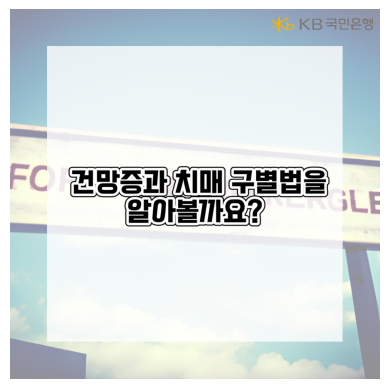

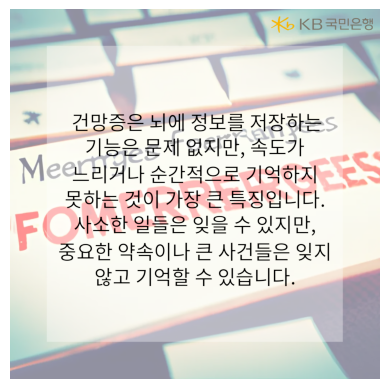

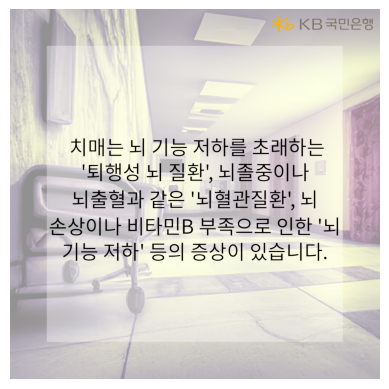

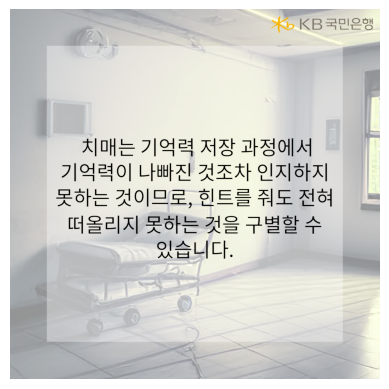

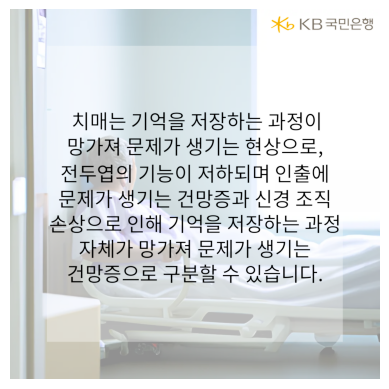

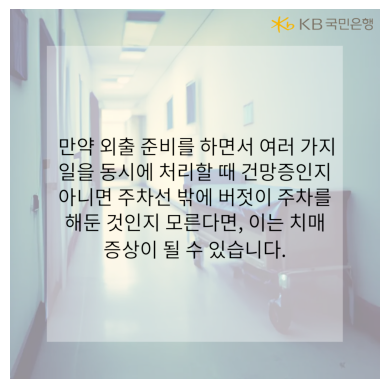

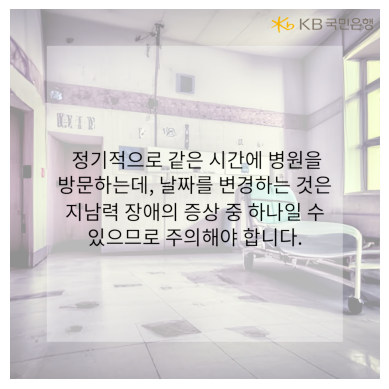

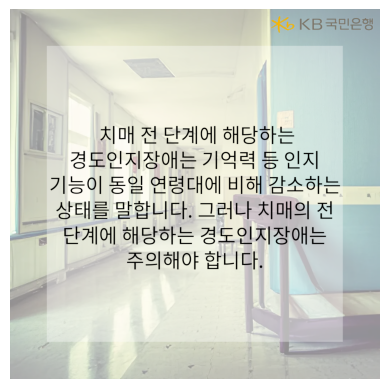

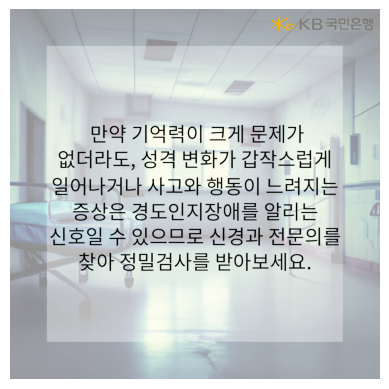

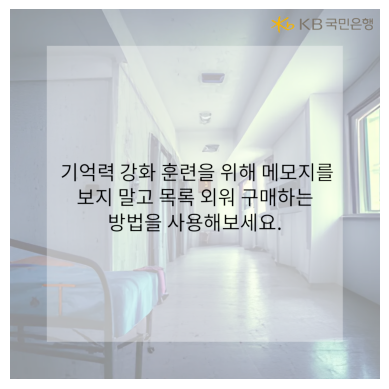

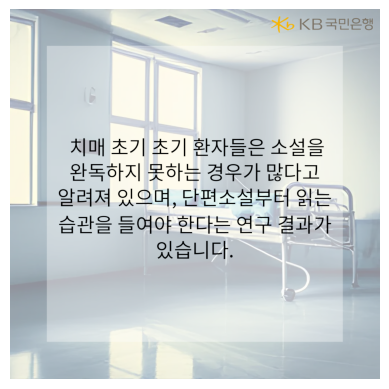

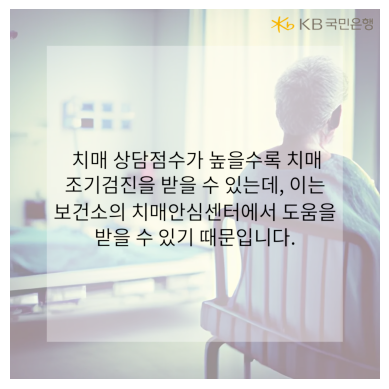

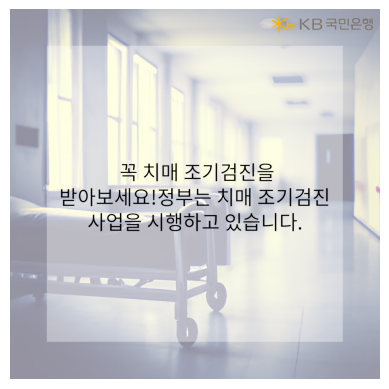

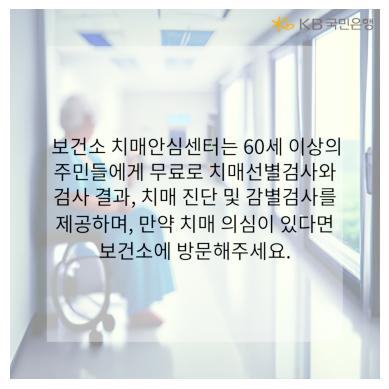

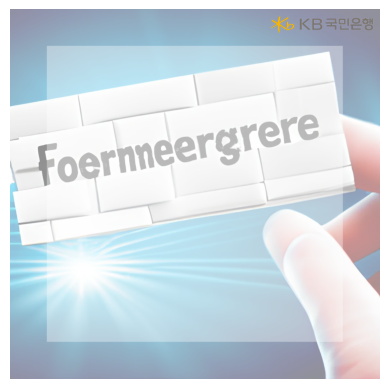

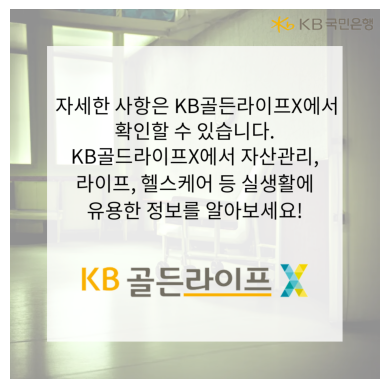

In [92]:
makeCardNews(text, keywords)